In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

from collections import Counter, defaultdict
import sentencepiece as spm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Corpus(object):
    def __init__(self,path='data/Sentiments/content.csv',train_sentencepiece=False,batch_size=64, val_size=10):
        self.path=path
        self.batch_size = batch_size
        self.val_size = val_size
        self.total_batch_size = batch_size+val_size
        self.minibatch_index = 0
        self.sp = spm.SentencePieceProcessor()
        if(train_sentencepiece): 
            spm.SentencePieceTrainer.Train(f'--input={self.path} --model_prefix=m --vocab_size=1250')
        self.sp.Load("m.model")
        
    def prep_data(self):
        subword_counter = Counter()
        num_of_tokens = 0
        with open(self.path,'r') as f:
            for line in f:
                line_subword = self.sp.EncodeAsPieces(line)
                subword_counter.update(self.sp.EncodeAsPieces(line))
                num_of_tokens += len(line_subword)+1

        self.subwords_itos = ['_unk_','_pad_','_eos_','_bos_'] + sorted(subword_counter,key=subword_counter.get,reverse=True)
        self.subwords_stoi = defaultdict(lambda:0,{k:i for i,k in enumerate(self.subwords_itos)})

        ids = torch.LongTensor(num_of_tokens)
        token = 0
        with open(self.path,'r') as f:
            for line in f:
                line_subword = self.sp.EncodeAsPieces(line) + ['_eos_']
                np_arr = np.array([self.subwords_stoi[s] for s in line_subword],np.int32)
                ids[token:token+len(line_subword)] = torch.from_numpy(np_arr)
                token += len(line_subword)

        num_batches = ids.size(0) // (self.total_batch_size)
        ids = ids[:num_batches*self.total_batch_size]
        self.full_data = ids.view(self.total_batch_size, -1)
        
    def get_minibatch(self,bptt=120):
        if (self.minibatch_index + bptt+1 > self.full_data.size(1)):
            self.minibatch_index=0
        self.last_mbatch_x = self.full_data[:self.batch_size,self.minibatch_index:self.minibatch_index+bptt]
        self.last_mbatch_y = self.full_data[:self.batch_size,1+self.minibatch_index:1+self.minibatch_index+bptt]
        self.last_mbatch_x_val = self.full_data[self.batch_size:,self.minibatch_index:self.minibatch_index+bptt]
        self.last_mbatch_y_val = self.full_data[self.batch_size:,1+self.minibatch_index:1+self.minibatch_index+bptt]
        self.minibatch_index+=bptt
        return(self.last_mbatch_x,self.last_mbatch_y,self.last_mbatch_x_val,self.last_mbatch_y_val)


In [4]:
corpus=Corpus()
corpus.prep_data()

In [5]:
class LangModel(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, dp_prob):
        super(LangModel,self).__init__()
    
        self.input_size=input_size
        self.embedding_size=embedding_size
        self.hidden_size=hidden_size
        self.dropout_prob=dp_prob
    
        self.dropout = nn.Dropout(dp_prob)
        self.emb_layer=nn.Embedding(input_size, embedding_size)
        self.rnn=nn.GRU(embedding_size, hidden_size, bidirectional=True)
        self.Linear=nn.Linear(2*hidden_size, input_size)
    
    def forward(self, input_sentence, init_hidden_state):
        #input_sentence: seq_len*batch_size
    
        emb=self.dropout(self.emb_layer(input_sentence))
        #emb: seq_len*batch_size*emb_size
    
        output, hidden=self.rnn(emb, init_hidden_state)
        #hidden: num_layers * num_directions, batch, hidden_size
    
        output=self.Linear(output.view(-1,2*hidden_size))
        
        return output

In [21]:
def train_minibatch(inputs, targets, hidden_size, mini_batch_size, model, model_optimizer, criterion, device=device):
    model_optimizer.zero_grad()
    hidden_state=(torch.zeros(2, mini_batch_size, hidden_size, device=device)).detach()
    outputs = model(inputs, hidden_state)
    #print (outputs.size(),targets.size())
    loss = criterion(outputs, targets.reshape(-1))
    loss.backward()
    model_optimizer.step()
    return loss.item()


In [22]:
def validate(inputs, targets, hidden_size, validation_size,criterion, device=device):
    with torch.no_grad():
        hidden_state=(torch.zeros(2, validation_size, hidden_size, device=device)).detach()
        outputs = model(inputs, hidden_state)
        val_loss = criterion(outputs, targets.reshape(-1))
        return val_loss

In [23]:
model=LangModel(input_size=1376, embedding_size=300, hidden_size=512, dp_prob=0.2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)
model_optimizer=optim.Adam(model.parameters())
criterion=nn.CrossEntropyLoss()

In [24]:
hidden_size=512
mini_batch_size=64
val_size=10
tl=[]
vl=[]

In [25]:
batch_training_loss=0
batch_validation_loss=0
val_loss_benchmark=1000
for i in range(2500):
    train_input, train_target, val_input, val_target=corpus.get_minibatch()
    train_input=Variable(train_input.cuda()).permute(1,0)
    train_target=Variable(train_target.cuda()).permute(1,0)
    val_input=Variable(val_input.cuda()).permute(1,0)
    val_target=Variable(val_target.cuda()).permute(1,0)
    train_loss=train_minibatch(train_input, train_target, hidden_size, mini_batch_size, model, model_optimizer, criterion)
    val_loss=validate(val_input, val_target, hidden_size, val_size,criterion)
    batch_training_loss+=train_loss
    batch_validation_loss+=val_loss
    if (i+1)%100==0:
        tl.append(batch_training_loss)
        vl.append(batch_validation_loss)
        print ('Step: {}/{} | Training Loss: {} | Validation Loss: {}'.format((i+1)/100, 100, batch_training_loss, batch_validation_loss))
        if (batch_validation_loss<=val_loss_benchmark):
            print ('%---Saving the model---%')
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_optimizer_state_dict': model_optimizer.state_dict(),
                },'models/LangModel_{}.pth'.format(int((i+1)/100)))
            val_loss_benchmark=batch_validation_loss
        batch_training_loss=0
        batch_validation_loss=0
    

Step: 1.0/100 | Training Loss: 274.2057755291462 | Validation Loss: 266.572021484375
%---Saving the model---%
Step: 2.0/100 | Training Loss: 12.023654393851757 | Validation Loss: 12.301753997802734
%---Saving the model---%
Step: 3.0/100 | Training Loss: 6.445833556354046 | Validation Loss: 6.441248416900635
%---Saving the model---%
Step: 4.0/100 | Training Loss: 5.551934204995632 | Validation Loss: 5.563888072967529
%---Saving the model---%
Step: 5.0/100 | Training Loss: 5.2104016952216625 | Validation Loss: 5.036572456359863
%---Saving the model---%
Step: 6.0/100 | Training Loss: 4.9375943168997765 | Validation Loss: 4.884289741516113
%---Saving the model---%
Step: 7.0/100 | Training Loss: 4.737070959061384 | Validation Loss: 4.797152519226074
%---Saving the model---%
Step: 8.0/100 | Training Loss: 4.680915292352438 | Validation Loss: 4.60063362121582
%---Saving the model---%
Step: 9.0/100 | Training Loss: 4.544412553310394 | Validation Loss: 4.633220195770264
Step: 10.0/100 | Trainin

In [29]:
checkpoint = torch.load('models/LangModel_22.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model_optimizer.load_state_dict(checkpoint['model_optimizer_state_dict'])
model.eval()

LangModel(
  (dropout): Dropout(p=0.2)
  (emb_layer): Embedding(1376, 300)
  (rnn): GRU(300, 512, bidirectional=True)
  (Linear): Linear(in_features=1024, out_features=1376, bias=True)
)

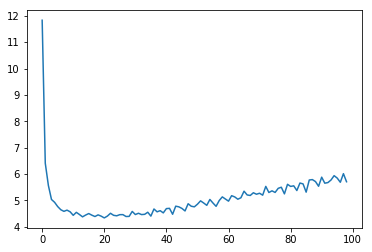

In [12]:
plt.plot(range(len(vl[1:])),vl[1:])
plt.show()

In [40]:
temp_begin = corpus.sp.EncodeAsPieces("Daha once bu yonet")
temp=torch.from_numpy(np.array([corpus.subwords_stoi[k] for k in temp_begin],np.int64))
temp=temp.unsqueeze(1)
temp=temp.type(torch.cuda.LongTensor)
temp.size()
newOutput=[0]
while int(newOutput[0]) != 2:
    with torch.no_grad():
        hidden_state=torch.zeros(2, 1, hidden_size, device=device)
        outputs = model(temp, hidden_state)
        newOutput = F.softmax(outputs,dim=1)
        #newOutput=newOutput.max(1)[1][-1]
        newOutput =torch.multinomial(newOutput[-1],1)[0]
        newOutput=newOutput.view(1)
        temp=torch.cat((temp, newOutput.unsqueeze(1)),dim=0)

In [33]:
a=[]
for i in range(1000):   
    temp_begin = corpus.sp.EncodeAsPieces("Daha once bu yonet")
    temp=torch.from_numpy(np.array([corpus.subwords_stoi[k] for k in temp_begin],np.int64))
    temp=temp.unsqueeze(1)
    temp=temp.type(torch.cuda.LongTensor)
    temp.size()
    newOutput=[0]

    with torch.no_grad():
        hidden_state=torch.zeros(2, 1, hidden_size, device=device)
        outputs = model(temp, hidden_state)
    a.append(corpus.subwords_itos[int(outputs.max(1)[1][-1])])


In [149]:
corpus.subwords_itos[int(outputs.max(1)[1][-1])]

'▁'

In [41]:
[corpus.subwords_itos[int(k)] for k in temp.detach().cpu().numpy()]

['▁D',
 'a',
 'ha',
 '▁o',
 'n',
 'ce',
 '▁bu',
 '▁',
 'yo',
 'ne',
 't',
 'ri',
 'k',
 'ın',
 'de',
 '▁pişman',
 'ım',
 '▁',
 'çe',
 'y',
 'ebil',
 'ebil',
 'eceğim',
 '▁kat',
 'ıl',
 'madan',
 'dım',
 '.',
 '▁tamamen',
 '▁sürü',
 ';',
 'j',
 'lı',
 'm',
 '.',
 'ama',
 '▁si',
 'k',
 '▁De',
 '▁De',
 'n',
 '▁yapıl',
 'sın',
 'ı',
 '▁di',
 'ken',
 '▁yemeği',
 '▁olarak',
 '▁yarat',
 '_eos_']

In [145]:
a=newOutput.view(1)
a.size()

AttributeError: 'list' object has no attribute 'view'

In [97]:
a

tensor([551], device='cuda:0')

In [171]:
(torch.zeros(1, 64, hidden_size).to(device),
              torch.zeros(1, 64, hidden_size).to(device))

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))